# Boson Star Notebook

Here are all the libraries we will use later.

In [3]:
import numpy as np
import pylab as pl
import matplotlib
import os

from IPython import display
from datetime import datetime
from scipy.optimize import minimize, curve_fit
from matplotlib import pyplot as plt
    
from BosonStar import BosonStar 

In [4]:
matplotlib.rcParams.update({'font.size': 13})

## 1) Define Ground State Field and Potential Functions 

Some time ago, I wrote a `BosonStar` class that calculates the wavefunction and potential profile for a boson star using the expansion. See the file `BosonStar.py` in the same directory as this notebook.  

You first initialize the `BosonStar` class for a given self interaction parameter `gamma`, and then use the function `BosonStar.get_profile(z)` to get the profile for an array of radii `z` at a specified order of the expansion. 

In [5]:
gamma=0
ground_state=BosonStar(gamma=gamma)

z=np.linspace(0,50,200)
s,v=ground_state.get_profile(z,z_match=1.3,n_near=10,n_far=4,m_far=4)

Let's plot the result

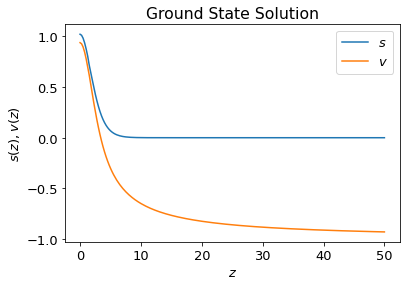

In [6]:
f=plt.figure() 
plt.plot(z,s,label=r"$s$")
plt.plot(z,v,label=r"$v$")
plt.xlabel(r'$z$')
plt.ylabel(r'$ s(z),  v(z)$')
plt.title('Ground State Solution')
plt.legend()
plt.show()

## 2) Numerical Solution for Pertubation in One-State Ansatz 

We now want to obtain a perturbed solution $s(z)=s_0(z) + \epsilon s_1(z)$ and $v(z)=v_0(z) + \epsilon  v_1(z)$, where the perturbation is specified by angular quantum numbers $\ell$ and $m$. The corresponding differential equations we need to solve are

\begin{equation}
 \nabla^2 s_1 = -v_1 s_0 - v_0 s_1 + 3 \gamma s_0^2 s_1 + \Gamma  s_1 \quad \text{and} \quad
 \nabla^2 v_1 = -2 s_1 s_0 
\end{equation}

When solving these equation we choose the following boundary conditions for the perturbed solution: $s_1|_{z=0}=0$, $v_1|_{z=0}=0$, $\partial_z s_1|_{z=0}=s_{11}$ and  $\partial_z v_1|_{z=0}=1$. In the last condition we used our freedom to normalize both $s_0$ and $v_0$, and set the slope of $v_1$ at the origin to be unity. The perturbed solution is therefore described by a single parameter: $\partial_z s_1|_{z=0}=s_{11}$. 

Let us first rewrite the differential equations a bit using $\nabla^2 s_1 = s_1'' + 2/z \times s_1'  - \ell(\ell+1)/z^2 \times s_1$. Now we can write

\begin{equation}
\begin{aligned}
ds_1/dz &= f_{s}(z,s_1,s_1',v_1,v_1')= s_1 ' \\
dv_1/dz &= f_{v}(z,s_1,s_1',v_1,v_1')= v_1 ' \\
ds_1'/dz&= f_{ds}(z,s_1,s_1',v_1,v_1')= -2/z \times s_1' + \ell(\ell+1)/z^2 \times s_1 - v_1 s_0 - v_0 s_1 + 3 \gamma s_0^2 s_1 + \Gamma s_1 \\
dv_1'/dz&= f_{dv}(z,s_1,s_1',v_1,v_1')=  -2/z \times v_1'+ \ell(\ell+1)/z^2 \times v_1 - 2 s_1 s_0 \\
\end{aligned}
\end{equation}

Let us now code up these differential equations:

In [7]:
def func_s(z,s1,s1p,v1,v1p,l,gamma,ggamma):
    return s1p
def func_v(z,s1,s1p,v1,v1p,l,gamma,ggamma):
    return v1p
def func_ds(z,s1,s1p,v1,v1p,l,gamma,ggamma):
    profile = ground_state.get_profile([z])
    s0, v0 = profile[0][0], profile[1][0]
    return -2./z*s1p + l*(l+1)/z**2*s1 - v1*s0 - v0*s1 + 3.*gamma*s0**2*s1 + ggamma*s1
def func_dv(z,s1,s1p,v1,v1p,l,gamma,ggamma):
    profile = ground_state.get_profile([z])
    s0, v0 = profile[0][0], profile[1][0]
    return -2./z*v1p + l*(l+1)/z**2*v1 - 2.*s1*s0 

Let's also define this usefull function which does one step in the Runge-Kutta-4 integration

In [8]:
def rungekutta_step(z, s1, ds1, v1, dv1 , h, l, gamma, ggamma): 
    
    k1_s  = func_s (z, s1, ds1, v1, dv1, l, gamma, ggamma)
    k1_ds = func_ds(z, s1, ds1, v1, dv1, l, gamma, ggamma)
    k1_v  = func_v (z, s1, ds1, v1, dv1, l, gamma, ggamma)
    k1_dv = func_dv(z, s1, ds1, v1, dv1, l, gamma, ggamma)
        
    k2_s  = func_s (z+h/2, s1+h/2*k1_s, ds1+h/2*k1_ds, v1+h/2*k1_v, dv1+h/2*k1_dv, l, gamma, ggamma)
    k2_ds = func_ds(z+h/2, s1+h/2*k1_s, ds1+h/2*k1_ds, v1+h/2*k1_v, dv1+h/2*k1_dv, l, gamma, ggamma)
    k2_v  = func_v (z+h/2, s1+h/2*k1_s, ds1+h/2*k1_ds, v1+h/2*k1_v, dv1+h/2*k1_dv, l, gamma, ggamma)
    k2_dv = func_dv(z+h/2, s1+h/2*k1_s, ds1+h/2*k1_ds, v1+h/2*k1_v, dv1+h/2*k1_dv, l, gamma, ggamma)
        
    k3_s  = func_s (z+h/2, s1+h/2*k2_s, ds1+h/2*k2_ds, v1+h/2*k2_v, dv1+h/2*k2_dv, l, gamma, ggamma)
    k3_ds = func_ds(z+h/2, s1+h/2*k2_s, ds1+h/2*k2_ds, v1+h/2*k2_v, dv1+h/2*k2_dv, l, gamma, ggamma)
    k3_v  = func_v (z+h/2, s1+h/2*k2_s, ds1+h/2*k2_ds, v1+h/2*k2_v, dv1+h/2*k2_dv, l, gamma, ggamma)
    k3_dv = func_dv(z+h/2, s1+h/2*k2_s, ds1+h/2*k2_ds, v1+h/2*k2_v, dv1+h/2*k2_dv, l, gamma, ggamma)
        
    k4_s  = func_s (z+h, s1+h*k3_s, ds1+h*k3_ds, v1+h*k3_v, dv1+h*k3_dv, l, gamma, ggamma)
    k4_ds = func_ds(z+h, s1+h*k3_s, ds1+h*k3_ds, v1+h*k3_v, dv1+h*k3_dv, l, gamma, ggamma)
    k4_v  = func_v (z+h, s1+h*k3_s, ds1+h*k3_ds, v1+h*k3_v, dv1+h*k3_dv, l, gamma, ggamma)
    k4_dv = func_dv(z+h, s1+h*k3_s, ds1+h*k3_ds, v1+h*k3_v, dv1+h*k3_dv, l, gamma, ggamma)
        
    ksum_s  = k1_s + 2*k2_s + 2*k3_s + k4_s
    ksum_ds = k1_ds+ 2*k2_ds+ 2*k3_ds+ k4_ds
    ksum_v  = k1_v + 2*k2_v + 2*k3_v + k4_v
    ksum_dv = k1_dv+ 2*k2_dv+ 2*k3_dv+ k4_dv
        
    step_s  = h/6.*ksum_s
    step_ds = h/6.*ksum_ds
    step_v  = h/6.*ksum_v
    step_dv = h/6.*ksum_dv
    
    return step_s, step_ds, step_v, step_dv

Now we can write a function for the integration algorithm: `onestatesolution(l,gamma,ggamma,s11)` which numerically calculates the perturbed profile for fixed values $\ell$, $\gamma$, $\Gamma$ and $s_{11}$. 

In [9]:
def onestatesolution(l,gamma,ggamma,s11,do_write=False):
   
    #step size 
    h=.01 
    
    #initial consitions
    z=h/2. 
    dS_1, dV_1 = s11, 1
    S_1, V_1 = dS_1*z, dV_1*z

    #prepare output
    output_z, output_S1, output_dS1, output_V1, output_dV1 = [], [], [], [], []
  
    #Condition to ensure I see full behaivior up to when the functions starts diverging.
    while(abs(S_1)<3) :
#    while(z<20) :
        
        output_z.append(z)
        output_S1.append(S_1)
        output_dS1.append(dS_1)
        output_V1.append(V_1)
        output_dV1.append(dV_1)
    
        step_s, step_ds, step_v, step_dv= rungekutta_step(z, S_1, dS_1, V_1, dV_1, h, l, gamma, ggamma)
        z    = z    + h
        S_1  = S_1  + step_s
        V_1  = V_1  + step_v
        dS_1 = dS_1 + step_ds
        dV_1 = dV_1 + step_dv
        
    return np.array(output_z),np.array(output_S1),np.array(output_dS1),np.array(output_V1),np.array(output_dV1)

Now, let's plot one solution for $\gamma=0$.

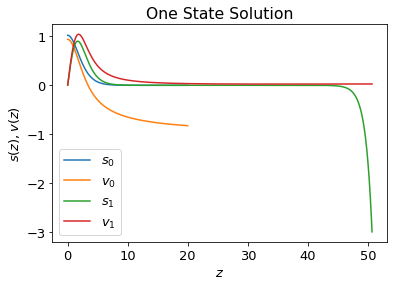

In [10]:
#get ground state
z0 =np.linspace(0,20,100)
s0,v0 = ground_state.get_profile(z0)

#get excited state
z1,s1,_,v1,_=onestatesolution(l=1, gamma=gamma, ggamma=0.000129469363981189, s11=0.918399213689316)

#plot
f=plt.figure() 
plt.plot(z0,s0,label=r"$s_0$")
plt.plot(z0,v0,label=r"$v_0$")
plt.plot(z1,s1,label=r"$s_1$")
plt.plot(z1,v1,label=r"$v_1$")
plt.xlabel(r'$z$')
plt.ylabel(r'$ s(z),v(z)$')
plt.title('One State Solution')
#plt.ylim(-1,1.1)
plt.legend()
plt.show()

#print ("We found the following solution:") 
#print ("   z=",z1) 
#print ("  S1=",s1) 
#print ("  V1=",v1) 

## 3) Find Physical Solution

We know that at large radii $z\gg1$, both the potential and the field should approach zero. However, for most values of $s_{11}$ and $\Gamma$, the solution will diverge as $s \sim e^z$ and $v \sim z$. We therefore search for a solution for which $|log s(z_{far})|$ and $|v(z_{far})|$ are minimized for some large value $z_{far} \gg 1$. 

So let us define $s_(z|s_{11},\Gamma)$ and $v(z|s_{11},\Gamma)$ as the numerical solutions for the profile corresponding to $s_{11}$ and $\Gamma$. We define a loss function 

\begin{equation}
L(\mu,\Gamma) = log |s(z_{far}|s_{11},\Gamma)| +  |v(z_{far}|s_{11},\Gamma)|
\end{equation}

In [11]:
def func_vfar(x, a, b):
    return a * x + b / x**2

result_array=[]
def lossfunction(x):

    #get solution for l=1 and gamma=0
    z1,s1,_,v1,_=onestatesolution(l=1, gamma=0, s11=x[0], ggamma=x[1])
    
    #get loss function
    ipos=10
    while ipos<len(s1) and abs(s1[ipos])>0.001: ipos+=1
    imin=min(int(0.7*len(z1)), ipos)
    while ipos<len(s1) and abs(s1[ipos])<0.1: ipos+=1
    imax=min(len(z1)-1, max(ipos,int(0.75*len(z1))))
    params, pcov = curve_fit(func_vfar, z1[imin:imax], v1[imin:imax])
    
    error = [] 
    for i in range(len(params)):
        try:
          error.append(np.absolute(pcov[i][i])**0.5)
        except:
          error.append( 0.00 )
    pfit_curvefit = params
    perr_curvefit = np.array(error)
    print( pfit_curvefit, perr_curvefit )
    
    
    #loss = alpha*np.log10(abs(s1[-1])) + (1-alpha)*np.log10(abs(params[0]))
    loss = z1[-1]*(-1 + 5*abs(params[0]) ) 
    
    #plot 
    f=plt.figure() 
    plt.plot(z0,s0,label=r"$s_0$")
    plt.plot(z0,v0,label=r"$v_0$")
    plt.plot(z1,s1,label=r"$s_1$")
    plt.plot(z1,v1,label=r"$v_1$")
    #plt.plot(z1,[func_vfar(z,params[0],params[1]) for z in z1],label=r"$s_0$", ls="dashed", c="k")
    plt.plot(z1[imin:imax], func_vfar(z1[imin:imax], *params),  ls="dashed", c="k") 
    plt.xlabel(r'$z$')
    plt.ylabel(r'$ s(z),v(z)$')
    plt.title('Ground State Solution')
    lims=[-1.2,1.2]
    plt.text(0,lims[0]+0.36*(lims[1]-lims[0]),r"ipos="+str(imin)+"/"+str(imax))
    plt.text(0,lims[0]+0.29*(lims[1]-lims[0]),r"v-slope="+str(round(params[0],10)))
    plt.text(0,lims[0]+0.22*(lims[1]-lims[0]),r"$s_{11}$="+str(round(x[0],10)))
    plt.text(0,lims[0]+0.15*(lims[1]-lims[0]),r"$\Gamma$="+str(round(x[1],10)))
    plt.text(0,lims[0]+0.08*(lims[1]-lims[0]),r"loss="+str(round(loss,5)))
    plt.legend(loc="upper right")
    plt.ylim(lims[0],lims[1])
    plt.grid(True)
    display.clear_output(wait=True)
    display.display(pl.gcf())   
    plt.close()
    
    #print output
    nowtime = datetime.now()
    with open("result.txt", "a") as myfile:
        myfile.write(str(x[0])+" "+str(x[1])+
            " "+str(s1[-1])+" "+str(params[0])+" "+str(loss)+
            " "+str( (nowtime-starttime).total_seconds())+"\n") 

    return loss

and use `scipy.optimize.minimize` to minimize it. 

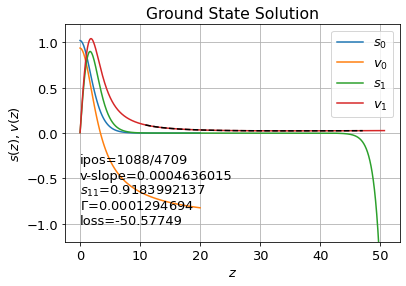

Optimization terminated successfully.
         Current function value: -50.577489
         Iterations: 125
         Function evaluations: 270


 final_simplex: (array([[9.18399214e-01, 1.29469364e-04],
       [9.18399214e-01, 1.29469364e-04],
       [9.18399214e-01, 1.29469364e-04]]), array([-50.57748861, -50.57748861, -50.57748861]))
           fun: -50.57748860672799
       message: 'Optimization terminated successfully.'
          nfev: 270
           nit: 125
        status: 0
       success: True
             x: array([9.18399214e-01, 1.29469364e-04])

In [12]:
if os.path.exists("result.txt"):os.remove("result.txt")
starttime = datetime.now()
minimize(lossfunction, (0.9184,0), method='Nelder-Mead', tol=1e-6, 
    options={'xatol': 0.0001, 'disp': True } )